# Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import sys, os
sys.path.append(os.path.join('..','LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor

# Dictionary to store execution times for each code block
execution_times = {}
# Dictionary to store power stats for each code block
power_stats = {}

## Processing data for monthly carbon intensity ##

In [26]:
with PowerMonitor(filename='power_Data_Processing.csv') as pm:
    start_time = time.time()

    df = pd.read_csv('../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df_filtered = df[df['DATETIME'].dt.year < 2025].copy()
    df_filtered.set_index('DATETIME', inplace=True)
    data_train = df_filtered['CARBON_INTENSITY'].resample('M').mean().dropna()
    data_train.head()

    execution_times['Data Processing'] = time.time() - start_time

power_stats['Data Processing'] = pm.stats()
print(f"Data Processing Time: {execution_times['Data Processing']:.4f} seconds")
print(f"Data Processing Power Stats: {power_stats['Data Processing']}")

Data Processing Time: 0.6826 seconds
Data Processing Power Stats: {'CPU Package': {'min': 13.356616020202637, 'max': 13.356616020202637, 'avg': 13.356616020202637, 'samples': 1}, 'CPU Cores': {'min': 13.343796730041504, 'max': 13.343796730041504, 'avg': 13.343796730041504, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'GPU Power': {'min': 0.008708851411938667, 'max': 0.008708851411938667, 'avg': 0.008708851411938667, 'samples': 1}}


C:\Users\tianw\AppData\Local\Temp\ipykernel_4648\715666515.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_train = df_filtered['CARBON_INTENSITY'].resample('M').mean().dropna()


## Fitting a SARIMA model to the data ##

In [27]:
with PowerMonitor(filename='power_Model_Fitting.csv') as pm:
    start_time = time.time()

    model = SARIMAX(data_train, order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 12), 
    enforce_stationarity=False,
    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())

    execution_times['Model Fitting'] = time.time() - start_time

power_stats['Model Fitting'] = pm.stats()
print(f"\nModel Fitting Time: {execution_times['Model Fitting']:.4f} seconds")
print(f"Model Fitting Power Stats: {power_stats['Model Fitting']}")

                                     SARIMAX Results                                      
Dep. Variable:                   CARBON_INTENSITY   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -785.731
Date:                            Wed, 17 Dec 2025   AIC                           1581.463
Time:                                    17:36:43   BIC                           1596.992
Sample:                                01-31-2009   HQIC                          1587.767
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3680      0.129      2.849      0.004       0.115       0.621
ma.L1         -0.7508      0.096   

## Generating and Plotting Forecasts for 2025 ##

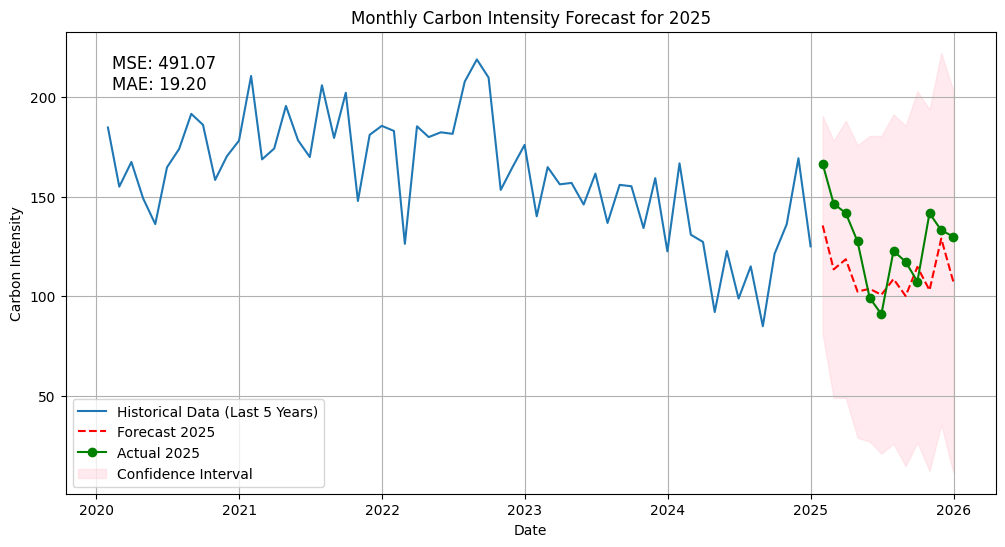


Forecasts for 2025:
              Forecast   Lower CI    Upper CI
2025-01-31  135.502569  80.677464  190.327674
2025-02-28  113.487578  49.061469  177.913686
2025-03-31  118.550148  49.033129  188.067166
2025-04-30  102.368882  29.060438  175.677327
2025-05-31  103.736842  27.133676  180.340009
2025-06-30  100.751612  21.096118  180.407105
2025-07-31  108.649688  26.091939  191.207436
2025-08-31  100.140425  14.792277  185.488574
2025-09-30  114.733676  26.688225  202.779127
2025-10-31  103.024203  12.363340  193.685065
2025-11-30  128.929470  35.727156  222.131784
2025-12-31  107.189578  11.513506  202.865649

Forecasting and Plotting Time: 0.1583 seconds
Forecasting Power Stats: None


In [28]:
with PowerMonitor(filename='power_Forecasting_and_Plotting.csv') as pm:
    start_time = time.time()

    # Forecast for 2025 (12 months)
    forecast_result = model_fit.get_forecast(steps=12)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()

    # Get actual 2025 data for comparison
    df_2025 = df[df['DATETIME'].dt.year == 2025].copy()
    df_2025.set_index('DATETIME', inplace=True)
    # Handle resampling compatibility
    try:
        actual_2025 = df_2025['CARBON_INTENSITY'].resample('ME').mean().dropna()
    except ValueError:
        actual_2025 = df_2025['CARBON_INTENSITY'].resample('M').mean().dropna()
    MSE = mean_squared_error(actual_2025, forecast_mean)
    MAE = mean_absolute_error(actual_2025, forecast_mean)
    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot recent history (last 5 years) for context
    history_subset = data_train.tail(60)
    plt.plot(history_subset.index, history_subset, label='Historical Data (Last 5 Years)')
    plt.plot(forecast_mean.index, forecast_mean, label='Forecast 2025', color='red', linestyle='--')
    plt.plot(actual_2025.index, actual_2025, label='Actual 2025', color='green', marker='o')
    plt.fill_between(forecast_mean.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.title('Monthly Carbon Intensity Forecast for 2025')
    plt.xlabel('Date')
    plt.ylabel('Carbon Intensity')
    plt.text(0.05, 0.95, f'MSE: {MSE:.2f}\nMAE: {MAE:.2f}', transform=plt.gca().transAxes, va='top', ha='left', fontsize=12)

    plt.legend()
    plt.grid(True)
    plt.show()

    # Display forecasts
    print("\nForecasts for 2025:")
    forecast_df = pd.DataFrame({'Forecast': forecast_mean, 'Lower CI': forecast_ci.iloc[:, 0], 'Upper CI': forecast_ci.iloc[:, 1]})
    print(forecast_df)

    execution_times['Forecasting and Plotting'] = time.time() - start_time
    power_stats['Forecasting and Plotting'] = pm.stats()
    print(f"\nForecasting and Plotting Time: {execution_times['Forecasting and Plotting']:.4f} seconds")
    print(f"Forecasting Power Stats: {power_stats['Forecasting and Plotting']}")



### Output the runtime and power usage, etc ###

In [30]:


# Print summary of all execution times
print("\n" + "="*50)
print("EXECUTION TIME SUMMARY")
print("="*50)
for task, duration in execution_times.items():
    print(f"{task}: {duration:.4f} seconds")
print(f"Total Time: {sum(execution_times.values()):.4f} seconds")
print("="*50)

# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


EXECUTION TIME SUMMARY
Data Processing: 0.6826 seconds
Model Fitting: 0.4694 seconds
Forecasting and Plotting: 0.1583 seconds
Total Time: 1.3103 seconds

POWER USAGE SUMMARY
Data Processing: {'CPU Package': {'min': 13.356616020202637, 'max': 13.356616020202637, 'avg': 13.356616020202637, 'samples': 1}, 'CPU Cores': {'min': 13.343796730041504, 'max': 13.343796730041504, 'avg': 13.343796730041504, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'GPU Power': {'min': 0.008708851411938667, 'max': 0.008708851411938667, 'avg': 0.008708851411938667, 'samples': 1}}
Model Fitting: {'CPU Package': {'min': 15.419919967651367, 'max': 15.419919967651367, 'avg': 15.419919967651367, 'samples': 1}, 'CPU Cores': {'min': 12.098557472229004, 'max': 12.098557472229004, 'avg': 12.098557472229004, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'm